In [2]:
pip install pandas numpy matplotlib scikit-learn nltk tqdm sentence-transformers torch torchvision torchaudio transformers accelerate tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
# SCRIPT 1: DATA PREPARATION (Phần cập nhật)
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm

# Đảm bảo các tài nguyên NLTK cần thiết đã được tải
def download_nltk_resources():
    # Thêm 'punkt_tab' vào danh sách tài nguyên cần kiểm tra và tải
    resources_to_download = {
        'punkt': 'tokenizers/punkt',
        'punkt_tab': 'tokenizers/punkt_tab', # Thêm dòng này
        'wordnet': 'corpora/wordnet.zip', # .zip là cách wordnet thường được lưu
        'stopwords': 'corpora/stopwords'
    }

    print("Checking and downloading NLTK resources...")
    for resource_name, resource_path_fragment in resources_to_download.items():
        try:
            nltk.data.find(resource_path_fragment)
            print(f"NLTK resource '{resource_name}' already downloaded.")
        except LookupError:
            print(f"Downloading NLTK resource: '{resource_name}'...")
            try:
                nltk.download(resource_name, quiet=False) # quiet=False để xem tiến trình tải
                print(f"Successfully downloaded '{resource_name}'.")
            except Exception as e:
                print(f"Error downloading NLTK resource '{resource_name}': {e}")
                print(f"Please try manually: import nltk; nltk.download('{resource_name}')")

# Gọi hàm này ở đầu script 1
download_nltk_resources()
tqdm.pandas(desc="Processing Text")

# ... (phần còn lại của SCRIPT 1: DATA PREPARATION giữ nguyên) ...

def load_and_combine_datasets(fake_paths, real_paths):
    datasets = []
    for path in fake_paths:
        try:
            df = pd.read_csv(path)
            df['label'] = 1  # Fake news
            datasets.append(df)
            print(f"Loaded {len(df)} fake samples from {path}")
        except FileNotFoundError:
            print(f"File not found: {path}. Skipping.")
        except Exception as e:
            print(f"Error loading {path}: {e}")

    for path in real_paths:
        try:
            df = pd.read_csv(path)
            df['label'] = 0  # Real news - SỬA LỖI GÁN NHÃN
            datasets.append(df)
            print(f"Loaded {len(df)} real samples from {path}")
        except FileNotFoundError:
            print(f"File not found: {path}. Skipping.")
        except Exception as e:
            print(f"Error loading {path}: {e}")

    if not datasets:
        raise ValueError("No data loaded. Check file paths and integrity.")

    combined_df = pd.concat(datasets, ignore_index=True)
    print(f"Total combined samples: {len(combined_df)}")
    return combined_df

def clean_text_basic(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'<.*?>', '', text) # Loại bỏ thẻ HTML
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # Giữ chữ, số, khoảng trắng; thay thế ký tự khác bằng khoảng trắng
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip() # Chuẩn hóa khoảng trắng
    return text

def preprocess_text_nltk_advanced(text, stemmer, lemmatizer, stop_words_set):
    if pd.isna(text) or not isinstance(text, str) or not text: # Kiểm tra text rỗng
        return ""

    # Giả định text đầu vào đã qua clean_text_basic
    tokens = word_tokenize(text) # Lỗi xảy ra ở đây nếu punkt_tab thiếu

    processed_tokens = [
        lemmatizer.lemmatize(stemmer.stem(token))
        for token in tokens
        if len(token) > 1 and token not in stop_words_set
    ]
    return " ".join(processed_tokens)

def prepare_data_main():
    print("--- Starting Script 1: Data Preparation ---")

    fake_files = ['gossipcop_fake.csv', 'politifact_fake.csv']
    real_files = ['gossipcop_real.csv', 'politifact_real.csv']

    data = load_and_combine_datasets(fake_files, real_files)

    print("\nCleaning data...")
    initial_size = len(data)

    if 'id' in data.columns:
        data.drop_duplicates(subset=['id'], inplace=True, keep='first')
        print(f"- Dropped {initial_size - len(data)} duplicates based on 'id'.")
        initial_size = len(data)

    data.dropna(subset=['title', 'label'], inplace=True)
    print(f"- Dropped {initial_size - len(data)} rows with missing 'title' or 'label'.")

    print("\nCreating 'cleaned_text_for_transformers' column...")
    data['cleaned_text_for_transformers'] = data['title'].progress_apply(clean_text_basic)

    print("\nCreating 'processed_text_nltk' column (stemmed, lemmatized)...")
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words_set = set(stopwords.words('english'))

    data['processed_text_nltk'] = data['cleaned_text_for_transformers'].progress_apply(
        lambda x: preprocess_text_nltk_advanced(x, stemmer, lemmatizer, stop_words_set)
    )

    data = data[data['cleaned_text_for_transformers'].str.strip().str.len() > 0]
    print(f"- Rows after ensuring 'cleaned_text_for_transformers' is not empty: {len(data)}")

    print("\nDataset Analysis:")
    print(f"- Total samples: {len(data)}")
    print(f"- Fake news (1): {len(data[data['label']==1])} | Real news (0): {len(data[data['label']==0])}")

    if not data.empty:
        print(f"- Avg. length 'cleaned_text_for_transformers': {data['cleaned_text_for_transformers'].str.len().mean():.0f} chars")
        print(f"- Avg. length 'processed_text_nltk': {data['processed_text_nltk'].str.len().mean():.0f} chars")

        plt.figure(figsize=(8, 5))
        data['label'].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Label Distribution (0: Real, 1: Fake)')
        plt.xticks([0, 1], ['Real News (0)', 'Fake News (1)'], rotation=0)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    else:
        print("Data is empty after processing, skipping plots and saving.")

    output_path = 'final_combined_data.csv'
    columns_to_save = ['id', 'news_url', 'title',
                       'cleaned_text_for_transformers',
                       'processed_text_nltk', 'label']
    final_columns = [col for col in columns_to_save if col in data.columns]
    if 'tweet_ids' in data.columns:
        final_columns.append('tweet_ids')

    if not data.empty:
        data[final_columns].to_csv(output_path, index=False)
        print(f"\nProcessed data saved to {output_path}")

    return data

if __name__ == "__main__":
    prepared_data = prepare_data_main()
    if prepared_data is not None and not prepared_data.empty: # Thêm kiểm tra prepared_data is not None
        print("\nFirst 5 rows of prepared data:")
        print(prepared_data[['title', 'cleaned_text_for_transformers', 'processed_text_nltk', 'label']].head())
    else:
        print("\nNo data was prepared or data is empty.")
    print("--- Script 1: Data Preparation Finished ---")

Checking and downloading NLTK resources...
NLTK resource 'punkt' already downloaded.
NLTK resource 'punkt_tab' already downloaded.
NLTK resource 'wordnet' already downloaded.
NLTK resource 'stopwords' already downloaded.
--- Starting Script 1: Data Preparation ---
File not found: gossipcop_fake.csv. Skipping.
File not found: politifact_fake.csv. Skipping.
File not found: gossipcop_real.csv. Skipping.
File not found: politifact_real.csv. Skipping.


ValueError: No data loaded. Check file paths and integrity.


--- Starting Script 2: Classical ML Models ---
Loaded 23191 samples for training classical models.
Training data size: 18552, Test data size: 4639

Loading SentenceTransformer model ('all-MiniLM-L6-v2')...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for training data...


Batches:   0%|          | 0/580 [00:00<?, ?it/s]

Generating embeddings for test data...


Batches:   0%|          | 0/145 [00:00<?, ?it/s]


--- Training Logistic Regression ---
Accuracy for Logistic Regression: 0.7560
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3488
           1       0.51      0.76      0.61      1151

    accuracy                           0.76      4639
   macro avg       0.70      0.76      0.71      4639
weighted avg       0.81      0.76      0.77      4639


--- Training Random Forest ---
Accuracy for Random Forest: 0.8069
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      3488
           1       0.82      0.28      0.42      1151

    accuracy                           0.81      4639
   macro avg       0.81      0.63      0.65      4639
weighted avg       0.81      0.81      0.77      4639


--- Training SVM (Linear) ---
Accuracy for SVM (Linear): 0.7571
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3488
           1       0.51   

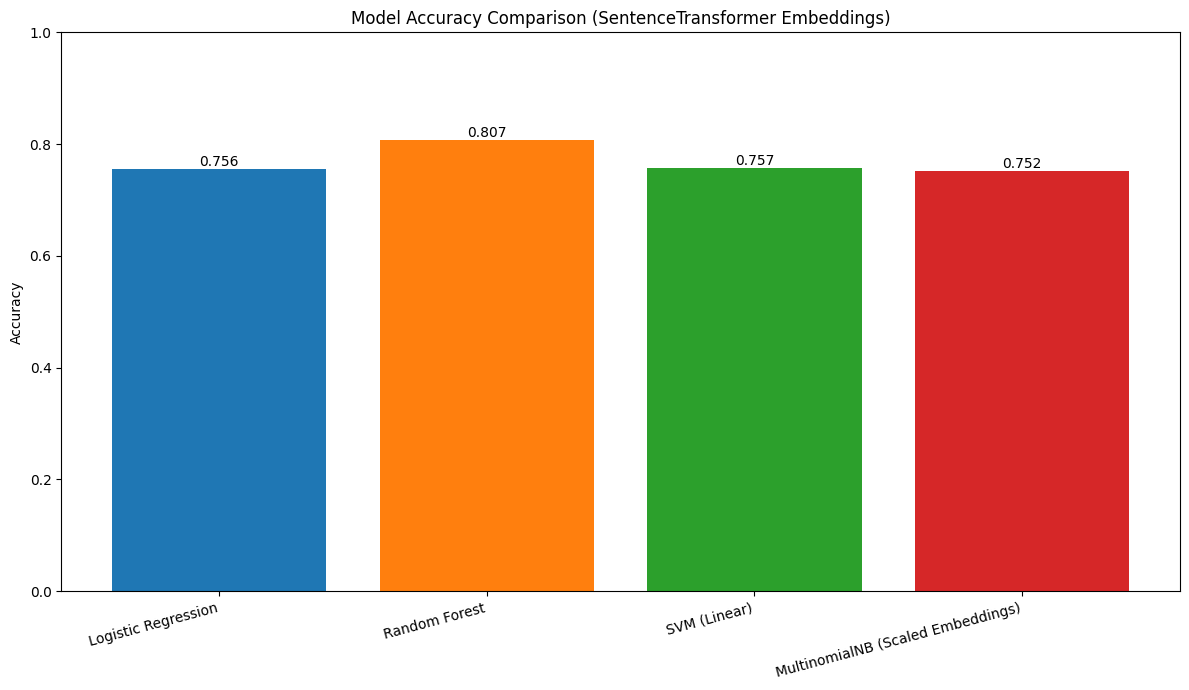


Saving SentenceTransformer model to saved_classical_models/sbert_model_all-MiniLM-L6-v2...
Scaler saved to saved_classical_models/min_max_scaler.pkl
Best classical model (Random Forest with accuracy 0.8069) saved to saved_classical_models/best_classifier_random_forest.pkl
To use this model, first load the SBERT model from 'saved_classical_models/sbert_model_all-MiniLM-L6-v2' to get embeddings.
--- Script 2: Classical ML Models Finished ---


In [3]:
# SCRIPT 2: CLASSICAL ML MODELS WITH SENTENCE TRANSFORMER
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # Dùng sau khi scale embeddings
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler # Để scale embeddings cho MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib
import os

def train_classical_models_main():
    print("\n--- Starting Script 2: Classical ML Models ---")
    input_path = 'final_combined_data.csv'

    if not os.path.exists(input_path):
        print(f"Error: {input_path} not found. Please run Script 1 first.")
        return

    data = pd.read_csv(input_path)

    # Đảm bảo không có giá trị NaN trong cột văn bản và nhãn
    data.dropna(subset=['cleaned_text_for_transformers', 'label'], inplace=True)
    data = data[data['cleaned_text_for_transformers'].astype(str).str.strip() != '']

    if data.empty:
        print("No data to train on after cleaning. Exiting.")
        return
    if data['label'].nunique() < 2:
        print("Error: Data contains only one class. Cannot train a classifier.")
        return

    print(f"Loaded {len(data)} samples for training classical models.")

    X = data['cleaned_text_for_transformers']
    y = data['label'].astype(int)

    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training data size: {len(X_train_text)}, Test data size: {len(X_test_text)}")

    # 1. Khởi tạo và tải mô hình SentenceTransformer
    print("\nLoading SentenceTransformer model ('all-MiniLM-L6-v2')...")
    sbert_model_name = 'all-MiniLM-L6-v2'
    sbert_model = SentenceTransformer(sbert_model_name)

    # 2. Tạo embeddings
    print("Generating embeddings for training data...")
    X_train_embeddings = sbert_model.encode(X_train_text.tolist(), show_progress_bar=True)
    print("Generating embeddings for test data...")
    X_test_embeddings = sbert_model.encode(X_test_text.tolist(), show_progress_bar=True)

    # 3. Scale embeddings cho MultinomialNB (vì nó yêu cầu đầu vào không âm)
    scaler = MinMaxScaler()
    X_train_embeddings_scaled = scaler.fit_transform(X_train_embeddings)
    X_test_embeddings_scaled = scaler.transform(X_test_embeddings)

    # 4. Định nghĩa và huấn luyện các mô hình
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
        'MultinomialNB (Scaled Embeddings)': MultinomialNB() # Sử dụng embeddings đã scale
    }

    results = {}
    best_model_instance = None
    best_model_name = None
    best_accuracy = 0.0

    for name, model_instance in models.items():
        print(f"\n--- Training {name} ---")
        try:
            if name == 'MultinomialNB (Scaled Embeddings)':
                model_instance.fit(X_train_embeddings_scaled, y_train)
                y_pred = model_instance.predict(X_test_embeddings_scaled)
            else:
                model_instance.fit(X_train_embeddings, y_train)
                y_pred = model_instance.predict(X_test_embeddings)

            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, zero_division=0)

            results[name] = {
                'model': model_instance,
                'accuracy': accuracy,
                'report_str': report,
                'report_dict': classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            }
            print(f"Accuracy for {name}: {accuracy:.4f}")
            print(report)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name = name
                best_model_instance = model_instance

        except Exception as e:
            print(f"Error training {name}: {e}")

    # 5. Trực quan hóa kết quả
    if results:
        model_names = list(results.keys())
        accuracies = [results[m]['accuracy'] for m in model_names]

        plt.figure(figsize=(12, 7))
        bars = plt.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title('Model Accuracy Comparison (SentenceTransformer Embeddings)')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.xticks(rotation=15, ha="right")
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

    # 6. Lưu mô hình
    output_model_dir = "saved_classical_models"
    os.makedirs(output_model_dir, exist_ok=True)

    # Lưu SentenceTransformer model
    sbert_save_path = os.path.join(output_model_dir, f"sbert_model_{sbert_model_name.replace('/','_')}")
    print(f"\nSaving SentenceTransformer model to {sbert_save_path}...")
    sbert_model.save(sbert_save_path) # SentenceTransformer có phương thức save riêng

    # Lưu Scaler (cần thiết cho MultinomialNB nếu nó là mô hình tốt nhất)
    scaler_save_path = os.path.join(output_model_dir, "min_max_scaler.pkl")
    joblib.dump(scaler, scaler_save_path)
    print(f"Scaler saved to {scaler_save_path}")

    if best_model_instance:
        best_model_filename = f"best_classifier_{best_model_name.replace(' ', '_').replace('(','').replace(')','').lower()}.pkl"
        best_model_save_path = os.path.join(output_model_dir, best_model_filename)
        joblib.dump(best_model_instance, best_model_save_path)
        print(f"Best classical model ({best_model_name} with accuracy {best_accuracy:.4f}) saved to {best_model_save_path}")
        print(f"To use this model, first load the SBERT model from '{sbert_save_path}' to get embeddings.")
        if "MultinomialNB" in best_model_name:
             print(f"Then, load the scaler from '{scaler_save_path}' to scale the embeddings before prediction.")
    else:
        print("No model was successfully trained and selected as best.")

    print("--- Script 2: Classical ML Models Finished ---")

if __name__ == "__main__":
    train_classical_models_main()

In [4]:
# SCRIPT 3: FINE-TUNING BERT MODEL
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

# --- Cấu hình ---
BERT_MODEL_NAME = "bert-base-uncased" # Hoặc một mô hình khác như "vinai/phobert-base" nếu dữ liệu tiếng Việt
OUTPUT_DIR_BERT = "./bert_training_results"
LOGGING_DIR_BERT = "./bert_training_logs"
FINE_TUNED_MODEL_SAVE_PATH = "./fine_tuned_bert_model"
MAX_SEQ_LENGTH = 256  # Giảm nếu gặp lỗi CUDA out of memory
TRAIN_BATCH_SIZE_BERT = 8
EVAL_BATCH_SIZE_BERT = 16
NUM_TRAIN_EPOCHS_BERT = 3 # 2-4 epochs thường là tốt cho fine-tuning
LEARNING_RATE_BERT = 2e-5 # Tốc độ học phổ biến cho BERT
# --- ---

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) # Đảm bảo text là string
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False, # Không cần cho BERT sequence classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Trả về PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics_bert(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def fine_tune_bert_main():
    print("\n--- Starting Script 3: Fine-tuning BERT Model ---")
    input_path = 'final_combined_data.csv'

    if not os.path.exists(input_path):
        print(f"Error: {input_path} not found. Please run Script 1 first.")
        return

    data = pd.read_csv(input_path)
    data.dropna(subset=['cleaned_text_for_transformers', 'label'], inplace=True)
    data = data[data['cleaned_text_for_transformers'].astype(str).str.strip() != '']

    if data.empty:
        print("No data to train on after cleaning. Exiting.")
        return
    if data['label'].nunique() < 2:
        print("Error: Data contains only one class. Cannot train a classifier.")
        return

    print(f"Loaded {len(data)} samples for fine-tuning BERT.")

    # Sử dụng cột `cleaned_text_for_transformers` cho BERT
    texts = data['cleaned_text_for_transformers'].tolist()
    labels = data['label'].astype(int).tolist()

    # Chia tập train và validation
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.15, random_state=42, stratify=labels # 15% cho validation
    )

    print(f"BERT Training data size: {len(train_texts)}, Validation data size: {len(val_texts)}")

    # Tải tokenizer và model
    print(f"Loading tokenizer and model: {BERT_MODEL_NAME}...")
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=2) # 2 nhãn (fake/real)

    # Tạo datasets
    train_dataset = NewsDataset(train_texts, train_labels, tokenizer, MAX_SEQ_LENGTH)
    val_dataset = NewsDataset(val_texts, val_labels, tokenizer, MAX_SEQ_LENGTH)

    # Định nghĩa TrainingArguments
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR_BERT,
        num_train_epochs=NUM_TRAIN_EPOCHS_BERT,
        per_device_train_batch_size=TRAIN_BATCH_SIZE_BERT,
        per_device_eval_batch_size=EVAL_BATCH_SIZE_BERT,
        learning_rate=LEARNING_RATE_BERT,
        warmup_steps=int(len(train_dataset) / TRAIN_BATCH_SIZE_BERT * NUM_TRAIN_EPOCHS_BERT * 0.1), # 10% warmup
        weight_decay=0.01,
        logging_dir=LOGGING_DIR_BERT,
        logging_steps=max(1, int(len(train_dataset) / TRAIN_BATCH_SIZE_BERT / 10)), # Log 10 lần mỗi epoch

        # SỬA LỖI Ở ĐÂY:
        eval_strategy="epoch",         # Tên mới cho chiến lược đánh giá
        save_strategy="epoch",         # Tên này thường vẫn đúng cho chiến lược lưu
                                       # Nếu vẫn lỗi với save_strategy, bạn có thể cần xem xét phiên bản thư viện
                                       # hoặc các tùy chọn khác như `hub_strategy` nếu đẩy lên Hub.

        load_best_model_at_end=True, # Tải model tốt nhất khi kết thúc
        metric_for_best_model="f1",  # Sử dụng F1 để chọn model tốt nhất
        greater_is_better=True,
        fp16=torch.cuda.is_available(), # Sử dụng mixed precision nếu có GPU
        report_to="tensorboard", # Hoặc "wandb"
        save_total_limit=2, # Chỉ lưu 2 checkpoint tốt nhất
    )

    # Khởi tạo Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_bert,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Dừng sớm nếu không cải thiện sau 2 epoch
    )

    # Huấn luyện
    print("\nStarting BERT fine-tuning...")
    try:
        trainer.train()
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("CUDA out of memory. Try reducing MAX_SEQ_LENGTH, TRAIN_BATCH_SIZE_BERT, or EVAL_BATCH_SIZE_BERT.")
            print("Current settings: MAX_SEQ_LENGTH={}, TRAIN_BATCH_SIZE_BERT={}, EVAL_BATCH_SIZE_BERT={}".format(
                MAX_SEQ_LENGTH, TRAIN_BATCH_SIZE_BERT, EVAL_BATCH_SIZE_BERT
            ))
        else:
            print(f"An error occurred during training: {e}")
        return # Dừng script nếu có lỗi nghiêm trọng

    # Đánh giá model tốt nhất trên tập validation
    print("\nEvaluating the best model on the validation set...")
    eval_results = trainer.evaluate(eval_dataset=val_dataset) # Đảm bảo đánh giá trên val_dataset
    print("Validation results for the best model:")
    for key, value in eval_results.items():
        print(f"- {key}: {value:.4f}")

    # Lưu model và tokenizer
    os.makedirs(FINE_TUNED_MODEL_SAVE_PATH, exist_ok=True)
    print(f"\nSaving fine-tuned BERT model and tokenizer to {FINE_TUNED_MODEL_SAVE_PATH}...")
    trainer.save_model(FINE_TUNED_MODEL_SAVE_PATH) # save_model sẽ lưu model tốt nhất
    tokenizer.save_pretrained(FINE_TUNED_MODEL_SAVE_PATH)
    print("Model and tokenizer saved successfully.")

    print("--- Script 3: Fine-tuning BERT Model Finished ---")

if __name__ == "__main__":
    fine_tune_bert_main()


--- Starting Script 3: Fine-tuning BERT Model ---
Loaded 23191 samples for fine-tuning BERT.
BERT Training data size: 19712, Validation data size: 3479
Loading tokenizer and model: bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting BERT fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.379300,0.377719,0.841621,0.678899,0.685979,0.682421
2,0.306300,0.386585,0.863179,0.790977,0.609502,0.688482
3,0.262600,0.541652,0.865191,0.737349,0.709154,0.722977



Evaluating the best model on the validation set...


Validation results for the best model:
- eval_loss: 0.5417
- eval_accuracy: 0.8652
- eval_precision: 0.7373
- eval_recall: 0.7092
- eval_f1: 0.7230
- eval_runtime: 13.5342
- eval_samples_per_second: 257.0520
- eval_steps_per_second: 16.1070
- epoch: 3.0000

Saving fine-tuned BERT model and tokenizer to ./fine_tuned_bert_model...
Model and tokenizer saved successfully.
--- Script 3: Fine-tuning BERT Model Finished ---


So sánh với Baseline


--- Starting Script 4: Baseline Models (TF-IDF) ---
Loaded 23187 samples for training baseline models using column 'processed_text_nltk'.
Baseline Training data size: 18549, Test data size: 4638

Vectorizing text with TF-IDF...
TF-IDF Matrix shape (Train): (18549, 5000)
TF-IDF Matrix shape (Test): (4638, 5000)
TF-IDF Vectorizer saved to saved_baseline_models/tfidf_vectorizer.pkl

--- Training Logistic Regression (TF-IDF) ---
Accuracy for Logistic Regression (TF-IDF): 0.8100
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      3487
           1       0.59      0.76      0.66      1151

    accuracy                           0.81      4638
   macro avg       0.75      0.79      0.77      4638
weighted avg       0.83      0.81      0.82      4638

Model Logistic Regression (TF-IDF) saved to saved_baseline_models/logistic_regression_tf-idf.pkl

--- Training Multinomial Naive Bayes (TF-IDF) ---
Accuracy for Multinomial Naive Bayes (TF-IDF)

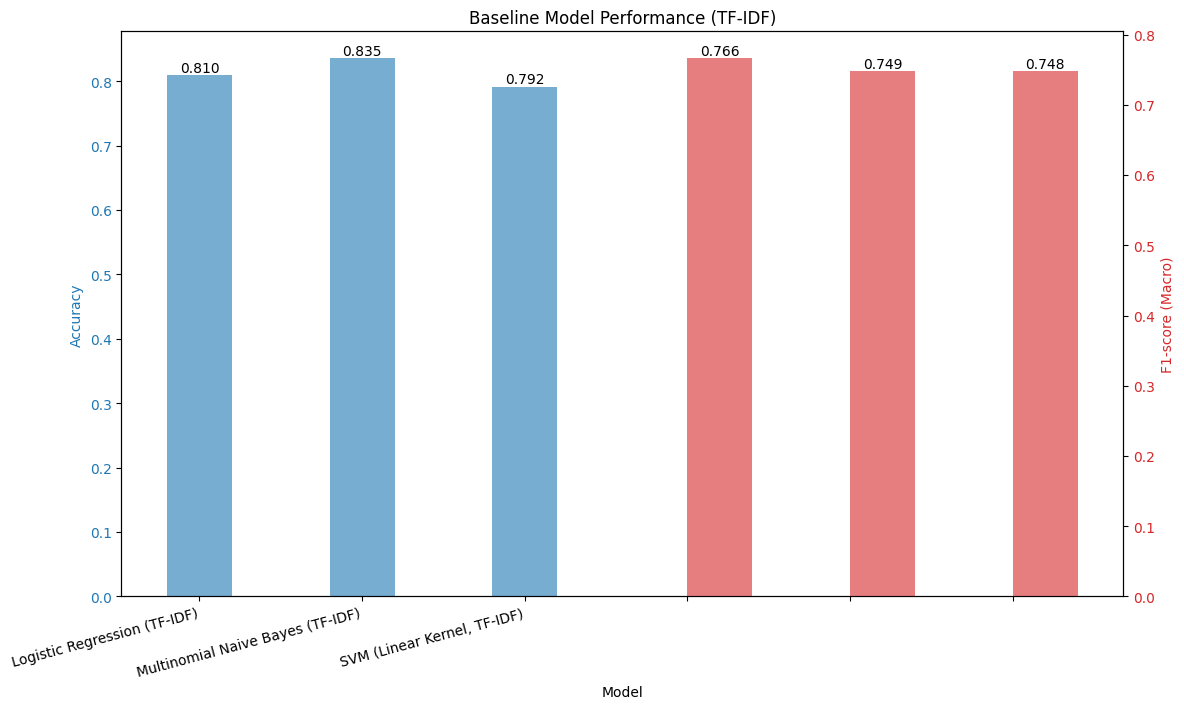

--- Script 4: Baseline Models (TF-IDF) Finished ---


In [5]:
# SCRIPT 4: BASELINE MODELS (TF-IDF + Classical ML)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os
import joblib # Để lưu model baseline nếu cần

def train_baseline_models_main():
    print("\n--- Starting Script 4: Baseline Models (TF-IDF) ---")
    input_path = 'final_combined_data.csv'

    if not os.path.exists(input_path):
        print(f"Error: {input_path} not found. Please run Script 1 first.")
        return {} # Trả về dictionary rỗng nếu lỗi

    data = pd.read_csv(input_path)

    # Đảm bảo không có giá trị NaN và văn bản rỗng
    # Sử dụng cột 'processed_text_nltk' cho baseline này
    # Hoặc bạn có thể thử 'cleaned_text_for_transformers' để so sánh
    text_column_for_baseline = 'processed_text_nltk'
    # text_column_for_baseline = 'cleaned_text_for_transformers' # Tùy chọn thay thế

    data.dropna(subset=[text_column_for_baseline, 'label'], inplace=True)
    data = data[data[text_column_for_baseline].astype(str).str.strip() != ''] # Loại bỏ text rỗng

    if data.empty:
        print(f"No data to train on after cleaning column '{text_column_for_baseline}'. Exiting.")
        return {}
    if data['label'].nunique() < 2:
        print("Error: Data contains only one class. Cannot train a classifier.")
        return {}

    print(f"Loaded {len(data)} samples for training baseline models using column '{text_column_for_baseline}'.")

    X_text = data[text_column_for_baseline]
    y = data['label'].astype(int)

    # QUAN TRỌNG: Sử dụng cùng random_state và test_size như các script khác để đảm bảo tính nhất quán
    # Giả sử bạn đã dùng test_size=0.2 và random_state=42 cho các mô hình khác
    # Nếu test_size cho BERT (Script 3) là 0.15, bạn nên cân nhắc sử dụng test_size nhất quán
    # ở đây chúng ta sẽ giữ 0.2 như Script 2 (Classical ML với SBERT)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Baseline Training data size: {len(X_train_text)}, Test data size: {len(X_test_text)}")

    # 1. Vector hóa văn bản bằng TF-IDF
    print("\nVectorizing text with TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # Giới hạn số features, sử dụng n-grams
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
    X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

    print(f"TF-IDF Matrix shape (Train): {X_train_tfidf.shape}")
    print(f"TF-IDF Matrix shape (Test): {X_test_tfidf.shape}")

    # 2. Định nghĩa và huấn luyện các mô hình baseline
    baseline_models = {
        'Logistic Regression (TF-IDF)': LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42),
        'Multinomial Naive Bayes (TF-IDF)': MultinomialNB(),
        'SVM (Linear Kernel, TF-IDF)': SVC(kernel='linear', class_weight='balanced', random_state=42)
    }

    baseline_results = {}
    output_baseline_model_dir = "saved_baseline_models"
    os.makedirs(output_baseline_model_dir, exist_ok=True)

    # Lưu TF-IDF Vectorizer
    tfidf_vectorizer_path = os.path.join(output_baseline_model_dir, "tfidf_vectorizer.pkl")
    joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
    print(f"TF-IDF Vectorizer saved to {tfidf_vectorizer_path}")

    for name, model_instance in baseline_models.items():
        print(f"\n--- Training {name} ---")
        try:
            model_instance.fit(X_train_tfidf, y_train)
            y_pred = model_instance.predict(X_test_tfidf)

            accuracy = accuracy_score(y_test, y_pred)
            report_str = classification_report(y_test, y_pred, zero_division=0)
            report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

            baseline_results[name] = {
                'model': model_instance, # Lưu instance của model đã huấn luyện
                'accuracy': accuracy,
                'precision_fake': report_dict.get('1', {}).get('precision', 0), # Precision cho lớp 1 (fake)
                'recall_fake': report_dict.get('1', {}).get('recall', 0),
                'f1_fake': report_dict.get('1', {}).get('f1-score', 0),
                'precision_real': report_dict.get('0', {}).get('precision', 0), # Precision cho lớp 0 (real)
                'recall_real': report_dict.get('0', {}).get('recall', 0),
                'f1_real': report_dict.get('0', {}).get('f1-score', 0),
                'f1_macro': report_dict.get('macro avg', {}).get('f1-score', 0),
                'f1_weighted': report_dict.get('weighted avg', {}).get('f1-score', 0),
                'report_str': report_str,
                'report_dict': report_dict
            }
            print(f"Accuracy for {name}: {accuracy:.4f}")
            print(report_str)

            # Lưu model baseline
            model_filename = f"{name.replace(' ', '_').replace('(','').replace(')','').lower()}.pkl"
            model_save_path = os.path.join(output_baseline_model_dir, model_filename)
            joblib.dump(model_instance, model_save_path)
            print(f"Model {name} saved to {model_save_path}")

        except Exception as e:
            print(f"Error training {name}: {e}")
            baseline_results[name] = {'error': str(e)} # Ghi lại lỗi nếu có

    # 3. Trực quan hóa và hiển thị kết quả baseline (tùy chọn)
    if baseline_results and any('accuracy' in res for res in baseline_results.values()):
        model_names = [name for name, res in baseline_results.items() if 'accuracy' in res]
        accuracies = [baseline_results[m]['accuracy'] for m in model_names]
        f1_macros = [baseline_results[m]['f1_macro'] for m in model_names]


        # Tạo DataFrame để dễ hiển thị
        results_df_data = []
        for name in model_names:
            res = baseline_results[name]
            results_df_data.append({
                'Model': name,
                'Accuracy': res['accuracy'],
                'F1 (Macro)': res['f1_macro'],
                'F1 (Fake)': res['f1_fake'],
                'F1 (Real)': res['f1_real']
            })
        results_df = pd.DataFrame(results_df_data)
        print("\n--- Baseline Model Performance Summary ---")
        print(results_df.to_string(index=False))


        # Biểu đồ
        fig, ax1 = plt.subplots(figsize=(12, 7))

        # Accuracy
        color = 'tab:blue'
        ax1.set_xlabel('Model')
        ax1.set_ylabel('Accuracy', color=color)
        bars_acc = ax1.bar([name + " (Acc)" for name in model_names], accuracies, color=color, alpha=0.6, width=0.4, align='center')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xticklabels(model_names, rotation=15, ha="right") # Chỉ đặt xticklabels một lần

        # F1-score (Macro)
        ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel('F1-score (Macro)', color=color) # we already handled the x-label with ax1
        bars_f1 = ax2.bar([name + " (F1)" for name in model_names], f1_macros, color=color, alpha=0.6, width=0.4, align='edge')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout() # otherwise the right y-label is slightly clipped
        plt.title('Baseline Model Performance (TF-IDF)')

        # Thêm text cho bars
        for bar in bars_acc:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        for bar in bars_f1:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

        plt.show()

    print("--- Script 4: Baseline Models (TF-IDF) Finished ---")
    return baseline_results

if __name__ == "__main__":
    baseline_performance = train_baseline_models_main()
    # Bạn có thể lưu `baseline_performance` vào file JSON hoặc CSV nếu muốn
    # Ví dụ:
    # import json
    # if baseline_performance:
    #     with open('baseline_performance_summary.json', 'w') as f:
    #         # Không thể serialize trực tiếp model instance, chỉ lưu metrics
    #         serializable_results = {}
    #         for model_name, metrics in baseline_performance.items():
    #             if 'model' in metrics: # Bỏ qua model instance
    #                 serializable_results[model_name] = {k: v for k, v in metrics.items() if k != 'model'}
    #             else:
    #                 serializable_results[model_name] = metrics
    #         json.dump(serializable_results, f, indent=4)
    #     print("\nBaseline performance summary saved to baseline_performance_summary.json")